In [1]:
# download nltk stopwords
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
import matplotlib.patches as patches
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\דניאלה\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Testing your app

Once your app is running you can query it. You can simply do that by clicking on the URL printed above (the one looking like https://XXXXX-5000-colab.googleusercontent.com/search?query=hello+world or by issuing an HTTP request through code (from colab).

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [2]:
with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [3]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [4]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [5]:
import math

def ndcg_at_k(true_list, predicted_list, k=100):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    
    # 1. חישוב DCG (הציון בפועל)
    dcg = 0.0
    for i, doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            # הוספת הניקוד: 1 חלקי לוג המיקום.
            # מוסיפים 2 כי האינדקס מתחיל ב-0 (אז המיקום הראשון הוא אינדקס 0 + 2 בלוג)
            dcg += 1.0 / math.log2(i + 2)
            
    # 2. חישוב IDCG (הציון האידיאלי)
    # במצב אידיאלי, כל המסמכים הרלוונטיים מופיעים בהתחלה
    num_relevant_items = len(true_set)
    
    # ה-IDCG מוגבל על ידי K או על ידי מספר המסמכים הרלוונטיים שיש בכלל
    n_ideal = min(k, num_relevant_items)
    
    idcg = 0.0
    for i in range(n_ideal):
        idcg += 1.0 / math.log2(i + 2)
        
    # 3. חישוב NDCG
    if idcg == 0.0:
        return 0.0
        
    return round(dcg / idcg, 3)

In [6]:
def visulize_results(option_res):
    cols = ['Query', 'Duration', 'RQ', 'P@5', 'P@10', 'Recall@40', 'F1@30', 'MAP', 'NDCG@K']
    df = pd.DataFrame(option_res, columns=cols)

    df = df.dropna()
    df['QueryID'] = range(1, len(df) + 1)

    metrics_config = [
        {'col': 'P@10',      'title': 'Precision @ 10',          'color': '#2a9d8f'}, # Teal
        {'col': 'Recall@40', 'title': 'Recall @ 40',             'color': '#264653'}, # Dark Blue
        {'col': 'F1@30',     'title': 'F1 Score @ 30',           'color': '#e9c46a'}, # Gold
        {'col': 'MAP',       'title': 'MAP', 'color': '#e76f51'}, # Orange/Red
        {'col': 'RQ',        'title': 'Results Quality (Harmonic)', 'color': '#8e44ad'}, # Purple
        {'col': 'NDCG@K','title': 'NDCG@K (Normalized Discounted Cumulative Gain)', 'color': "#52ff6e"}, # Purple
        {'col': 'Duration','title': 'Duration - retrieval time', 'color': "#ff52ab"}, # Purple
    ]
    sns.set_theme(style="white", context="paper")
    fig, axes = plt.subplots(4, 2, figsize=(18, 16))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_config):
        ax = axes[i]
        col_name = metric['col']
        color = metric['color']
        values = df[col_name]
        x = df['QueryID']

        mean_val = values.mean()
        median_val = values.median()
        max_val = values.max()
        max_idx = values.idxmax()
        min_val = values.min()
        min_idx = values.idxmin()
        
        x_max = df.loc[max_idx, 'QueryID']
        x_min = df.loc[min_idx, 'QueryID']

        sns.lineplot(x=x, y=values, ax=ax, color=color, linewidth=2, label='Score')
        ax.fill_between(x, values, color=color, alpha=0.1)

        ax.axhline(mean_val, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Mean')
        ax.axhline(median_val, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label='Median')

        ax.scatter(x_max, max_val, color='#d62728', s=100, zorder=5, edgecolor='white')
        ax.annotate(f'Max: {max_val:.2f}', (x_max, max_val), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=9, fontweight='bold', color='#d62728')
        
        ax.scatter(x_min, min_val, color='#d62728', s=100, zorder=5, edgecolor='white')
        ax.annotate(f'Min: {min_val:.2f}', (x_min, min_val), xytext=(0, -15), 
                    textcoords='offset points', ha='center', fontsize=9, fontweight='bold', color='#d62728')

        ax.set_title(metric['title'], fontsize=14, fontweight='bold', color='#333333', pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('Score')
        ax.grid(True, linestyle=':', alpha=0.6)
        
        sns.despine(ax=ax)

        stats_text = (
            f"$\\bf{{Stats}}$\n"
            f"Mean: {mean_val:.3f}\n"
            f"Median: {median_val:.3f}\n"
            f"Std: {values.std():.3f}"
        )
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#cccccc')
        ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right', 
                    bbox=props, fontfamily='monospace')

        ax.legend(loc='lower right', frameon=False, fontsize=8)

    plt.suptitle('Detailed Performance Analysis by Metric', fontsize=22, fontweight='heavy', y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [7]:
import requests


def get_results():
    url = 'http://35.239.201.94:8080' # CHANGE IP
    # url = 'http://127.0.0.1:5000'

    qs_res = []


    for q, true_wids in queries.items():
        duration = None
        # אתחול כל המדדים ל-None למקרה של כישלון
        rq, pr5, pr10, rec40, f1_30, map_val, mrr_val = [None] * 7
        
        t_start = time()
        try:
            res = requests.get(url + '/search', {'query': q}, timeout=35)
            duration = time() - t_start
            
            if res.status_code == 200:
                pred_wids, _ = zip(*res.json()) # הנחה שהפורמט הוא [(id, title), ...]
                
                rq = results_quality(true_wids, pred_wids)
                
                pr5 = precision_at_k(true_wids, pred_wids, 5)
                pr10 = precision_at_k(true_wids, pred_wids, 10)
                
                rec40 = recall_at_k(true_wids, pred_wids, 40)
                
                f1_30 = f1_at_k(true_wids, pred_wids, 30)
                
                map_val = average_precision(true_wids, pred_wids, 100)
                ndcg_val = ndcg_at_k(true_wids, pred_wids, 100)

        except Exception as e:
            print(f"Error processing query '{q}': {e}")
            pass

        # שומרים את כל המדדים בטאפל
        qs_res.append((q, duration, rq, pr5, pr10, rec40, f1_30, map_val, ndcg_val))
    return qs_res

    x = np.arange(1, len(values) + 1)
    x_smooth = np.linspace(x.min(), x.max(), 300) 
    spl = make_interp_spline(x, values, k=3) # אינטרפולציה מסדר 3
    y_smooth = spl(x_smooth)

    # גבולות למניעת ירידה מתחת לאפס בהחלקה (אם רלוונטי לנתונים חיוביים בלבד)
    y_smooth = np.maximum(y_smooth, 0)

    # --- 2. הגדרות עיצוב כלליות ---
    sns.set_theme(style="white", context="talk") # סגנון נקי וקריא
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # פלטת צבעים יוקרתית (כחול עמוק וזהב/כתום)
    color_line = "#1f4e79"   # Deep Professional Blue
    color_fill = "#1f4e79"
    color_accent = "#d95f02" # Deep Orange/Rust for highlights
    color_grid = "#e0e0e0"

    # --- 3. ציור הגרף ---
    
    # רשת (Grid) מותאמת אישית ועדינה
    ax.grid(color=color_grid, linestyle=':', linewidth=1, alpha=0.8, zorder=0)
    
    # ציור הקו המוחלק
    ax.plot(x_smooth, y_smooth, color=color_line, linewidth=3.5, label='Trend (Smoothed)', zorder=3)
    
    # מילוי שטח מתחת לקו עם שקיפות מדורגת (אפקט עומק)
    ax.fill_between(x_smooth, y_smooth, color=color_fill, alpha=0.15, zorder=1)

    # הוספת הנקודות המקוריות (כדי לשמור על אמינות הנתונים)
    ax.scatter(x, values, color=color_line, s=30, alpha=0.6, zorder=4, label='Raw Data')

    # --- 4. סטטיסטיקה והדגשות ---
    
    # חישוב מדדים
    max_val = np.max(values)
    min_val = np.min(values)
    avg_val = np.mean(values)
    std_dev = np.std(values)
    
    max_idx = np.argmax(values) + 1 # +1 כי האינדקס מתחיל מ-1
    min_idx = np.argmin(values) + 1

    # הוספת קו ממוצע
    ax.axhline(avg_val, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

    # הדגשת מקסימום עם חץ וטקסט
    ax.annotate(f'Peak Performance\nValue: {max_val:.1f}', 
                xy=(max_idx, max_val), xytext=(max_idx, max_val + (max_val*0.15)),
                arrowprops=dict(facecolor=color_accent, shrink=0.05, alpha=0.8, width=2, headwidth=8),
                fontsize=11, fontweight='bold', color=color_accent, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_accent, alpha=0.9))

    # הדגשת מינימום
    ax.annotate(f'Minimum Point\nValue: {min_val:.1f}', 
                xy=(min_idx, min_val), xytext=(min_idx, min_val - (max_val*0.15)),
                arrowprops=dict(facecolor=color_accent, shrink=0.05, alpha=0.8, width=2, headwidth=8),
                fontsize=11, fontweight='bold', color=color_accent, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_accent, alpha=0.9))

    # --- 5. תיבת מידע מסכמת (Insight Box) ---
    stats_text = (
        f"$\\bf{{Analysis\\ Summary}}$\n"  # כותרת בפורמט LaTeX
        f"----------------------\n"
        f"Mean: {avg_val:.2f}\n"
        f"Median: {np.median(values):.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Samples: {len(values)}"
    )
    
    # מיקום התיבה בפינה העליונה (משמאל או מימין בהתאם לגרף)
    props = dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.9, edgecolor='#cccccc')
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props, fontfamily='monospace')

    # --- 6. ליטוש סופי ---
    
    # כותרות
    plt.title('Comprehensive Score Analysis', fontsize=22, fontweight='bold', color='#333333', pad=20)
    plt.xlabel('Sequence Index', fontsize=14, fontweight='bold', labelpad=10, color='#555555')
    plt.ylabel('Measured Score', fontsize=14, fontweight='bold', labelpad=10, color='#555555')
    
    # הסרת מסגרת עליונה וימנית (Spines) למראה מודרני
    sns.despine(trim=True, offset=10)
    
    # התאמת גבולות ציר ה-Y כדי לתת "אוויר" לטקסטים
    plt.ylim(min_val - (max_val - min_val)*0.3, max_val + (max_val - min_val)*0.4)
    
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    plt.tight_layout()
    
    return plt


## Option1

In [ ]:
option1_res = get_results()

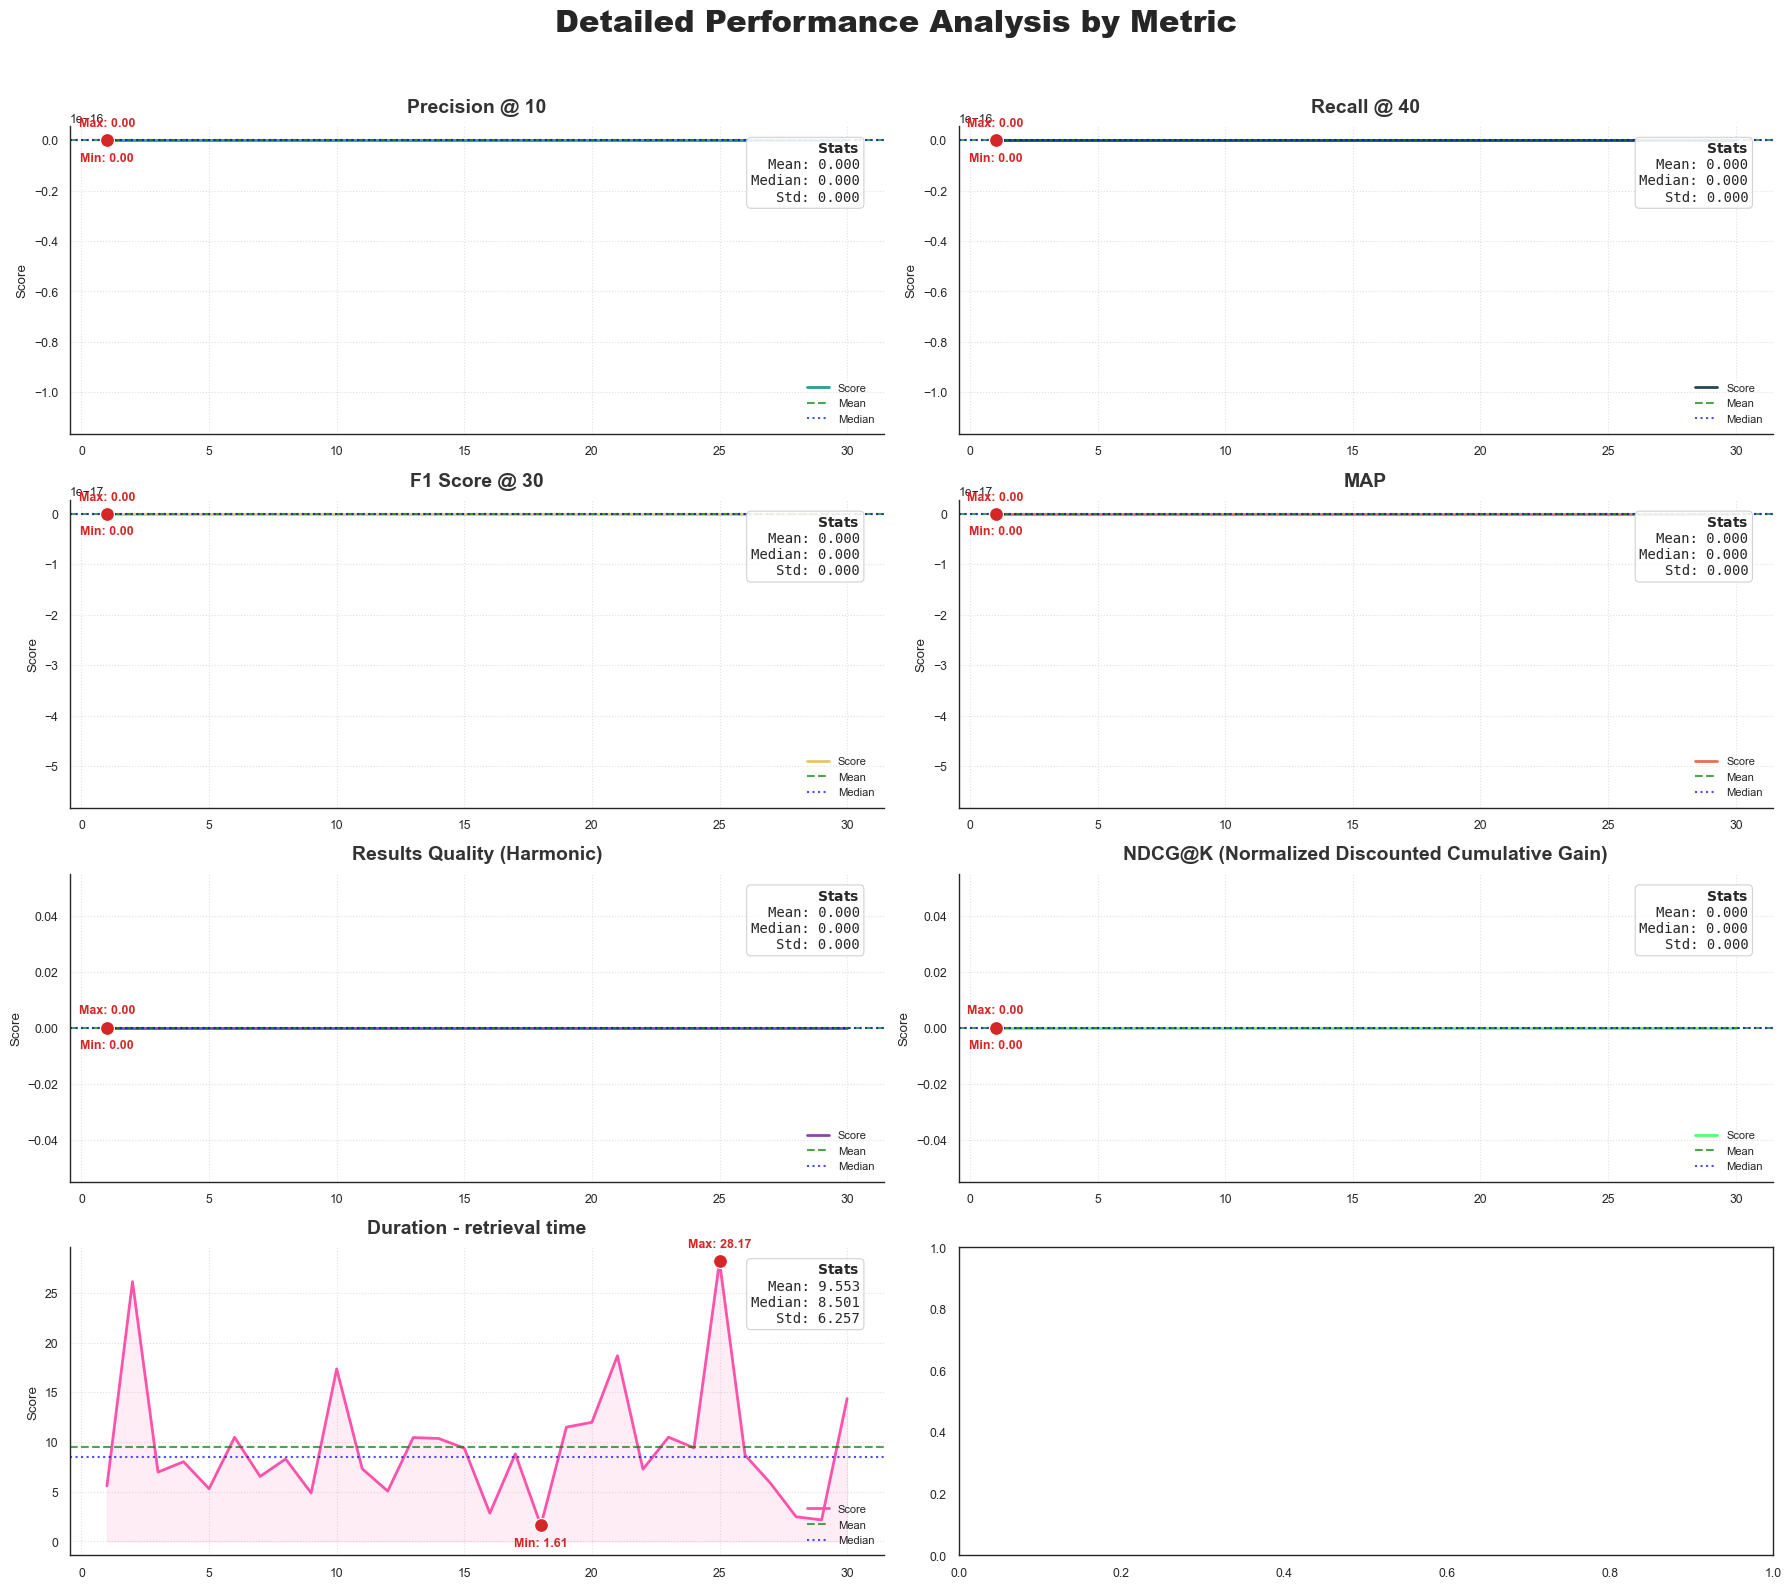

In [59]:
visulize_results(option1_res)

# Option 2

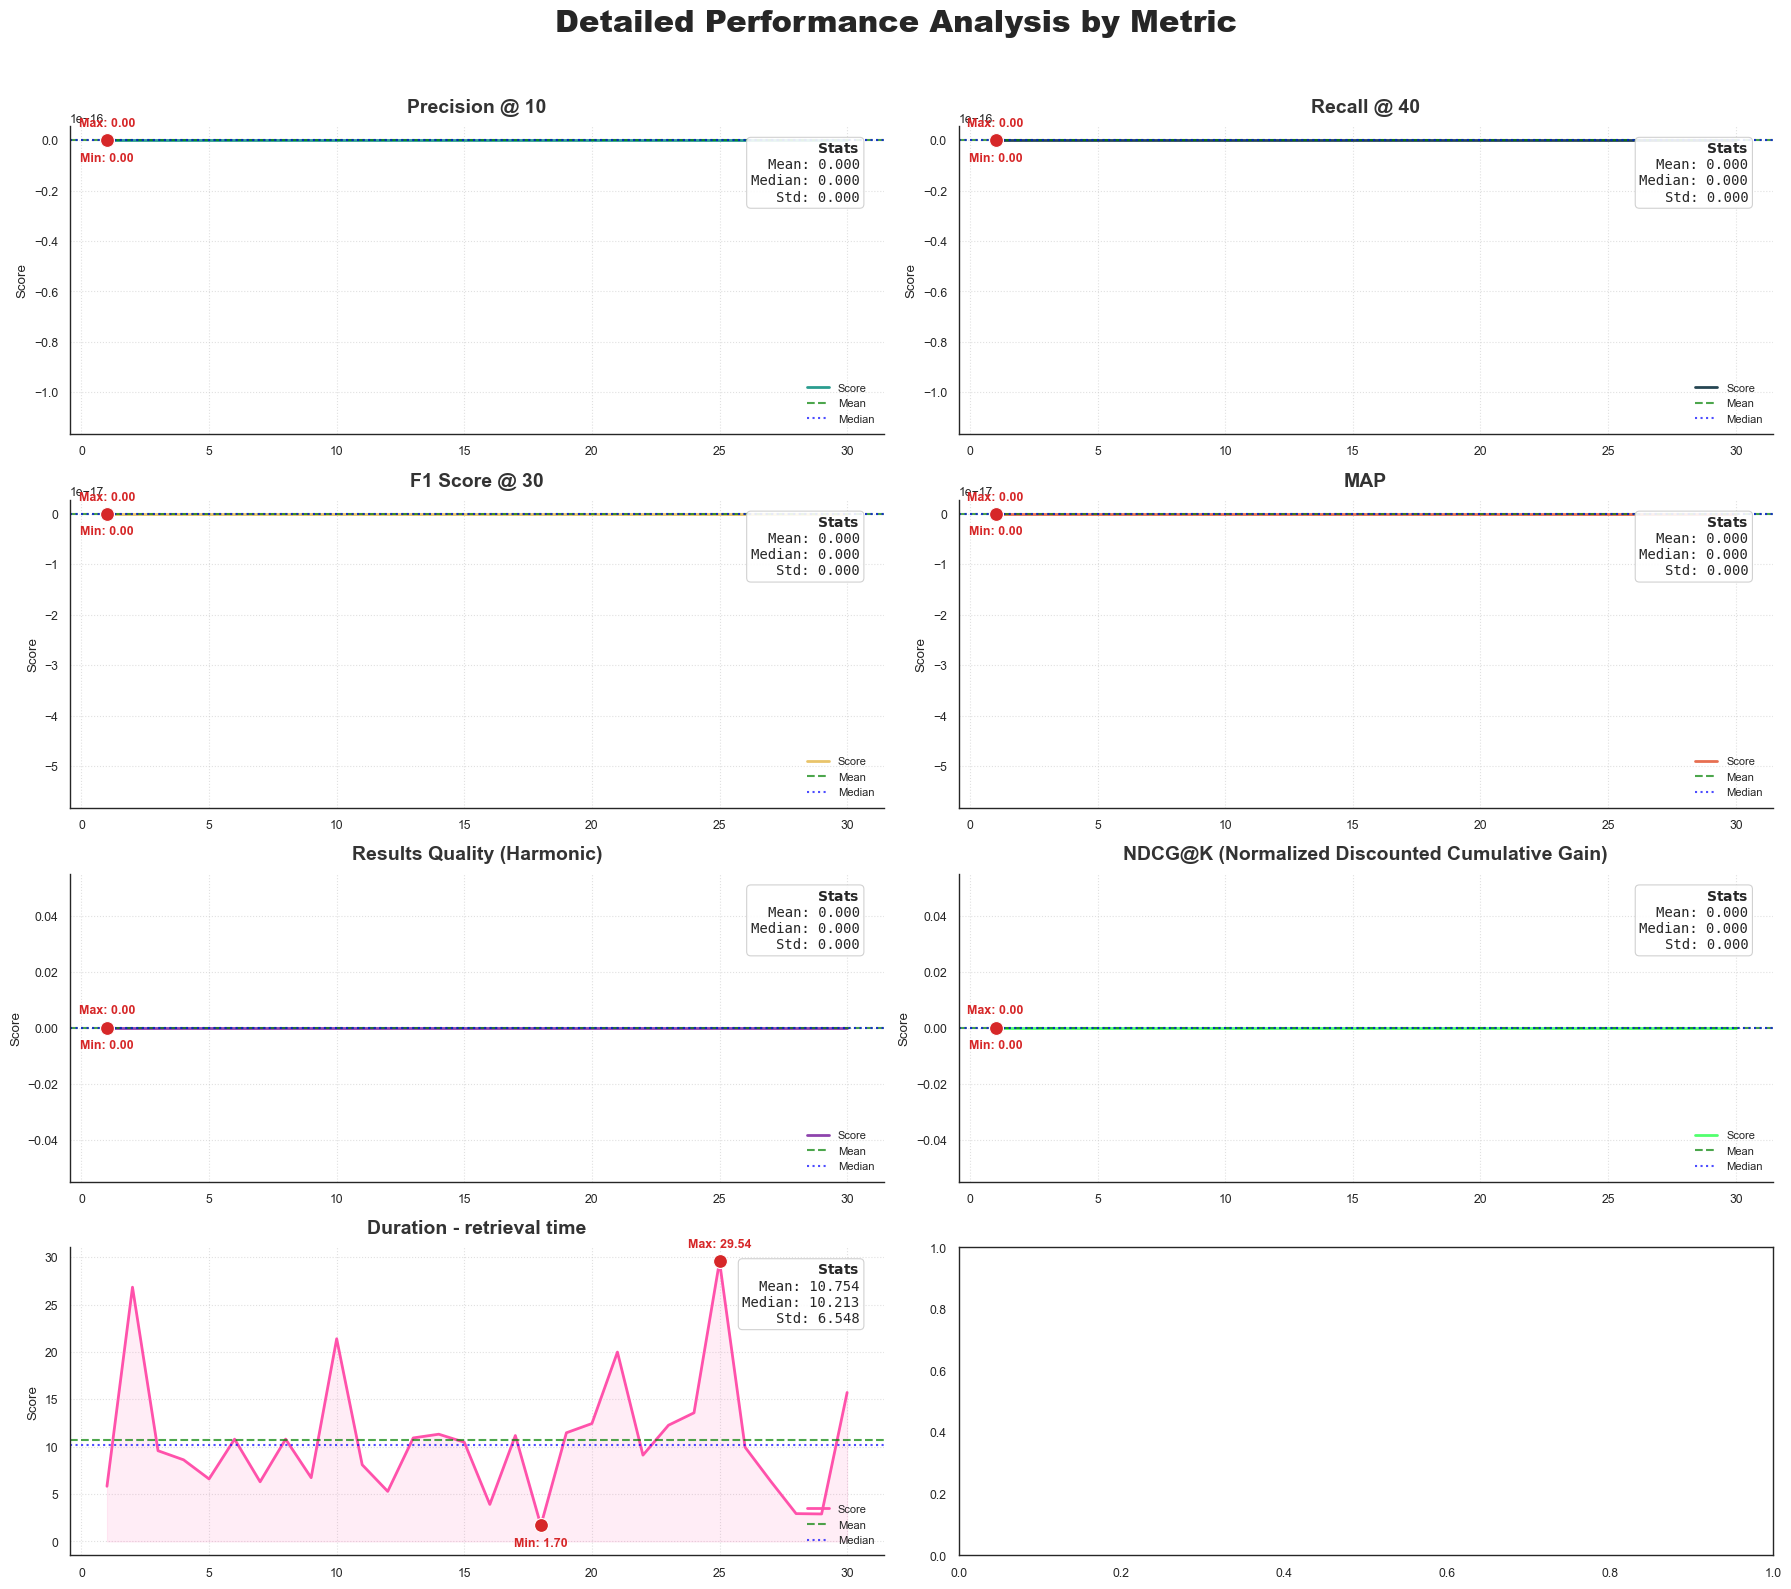

In [61]:
option2_res = get_results()
visulize_results(option2_res)

## Option3

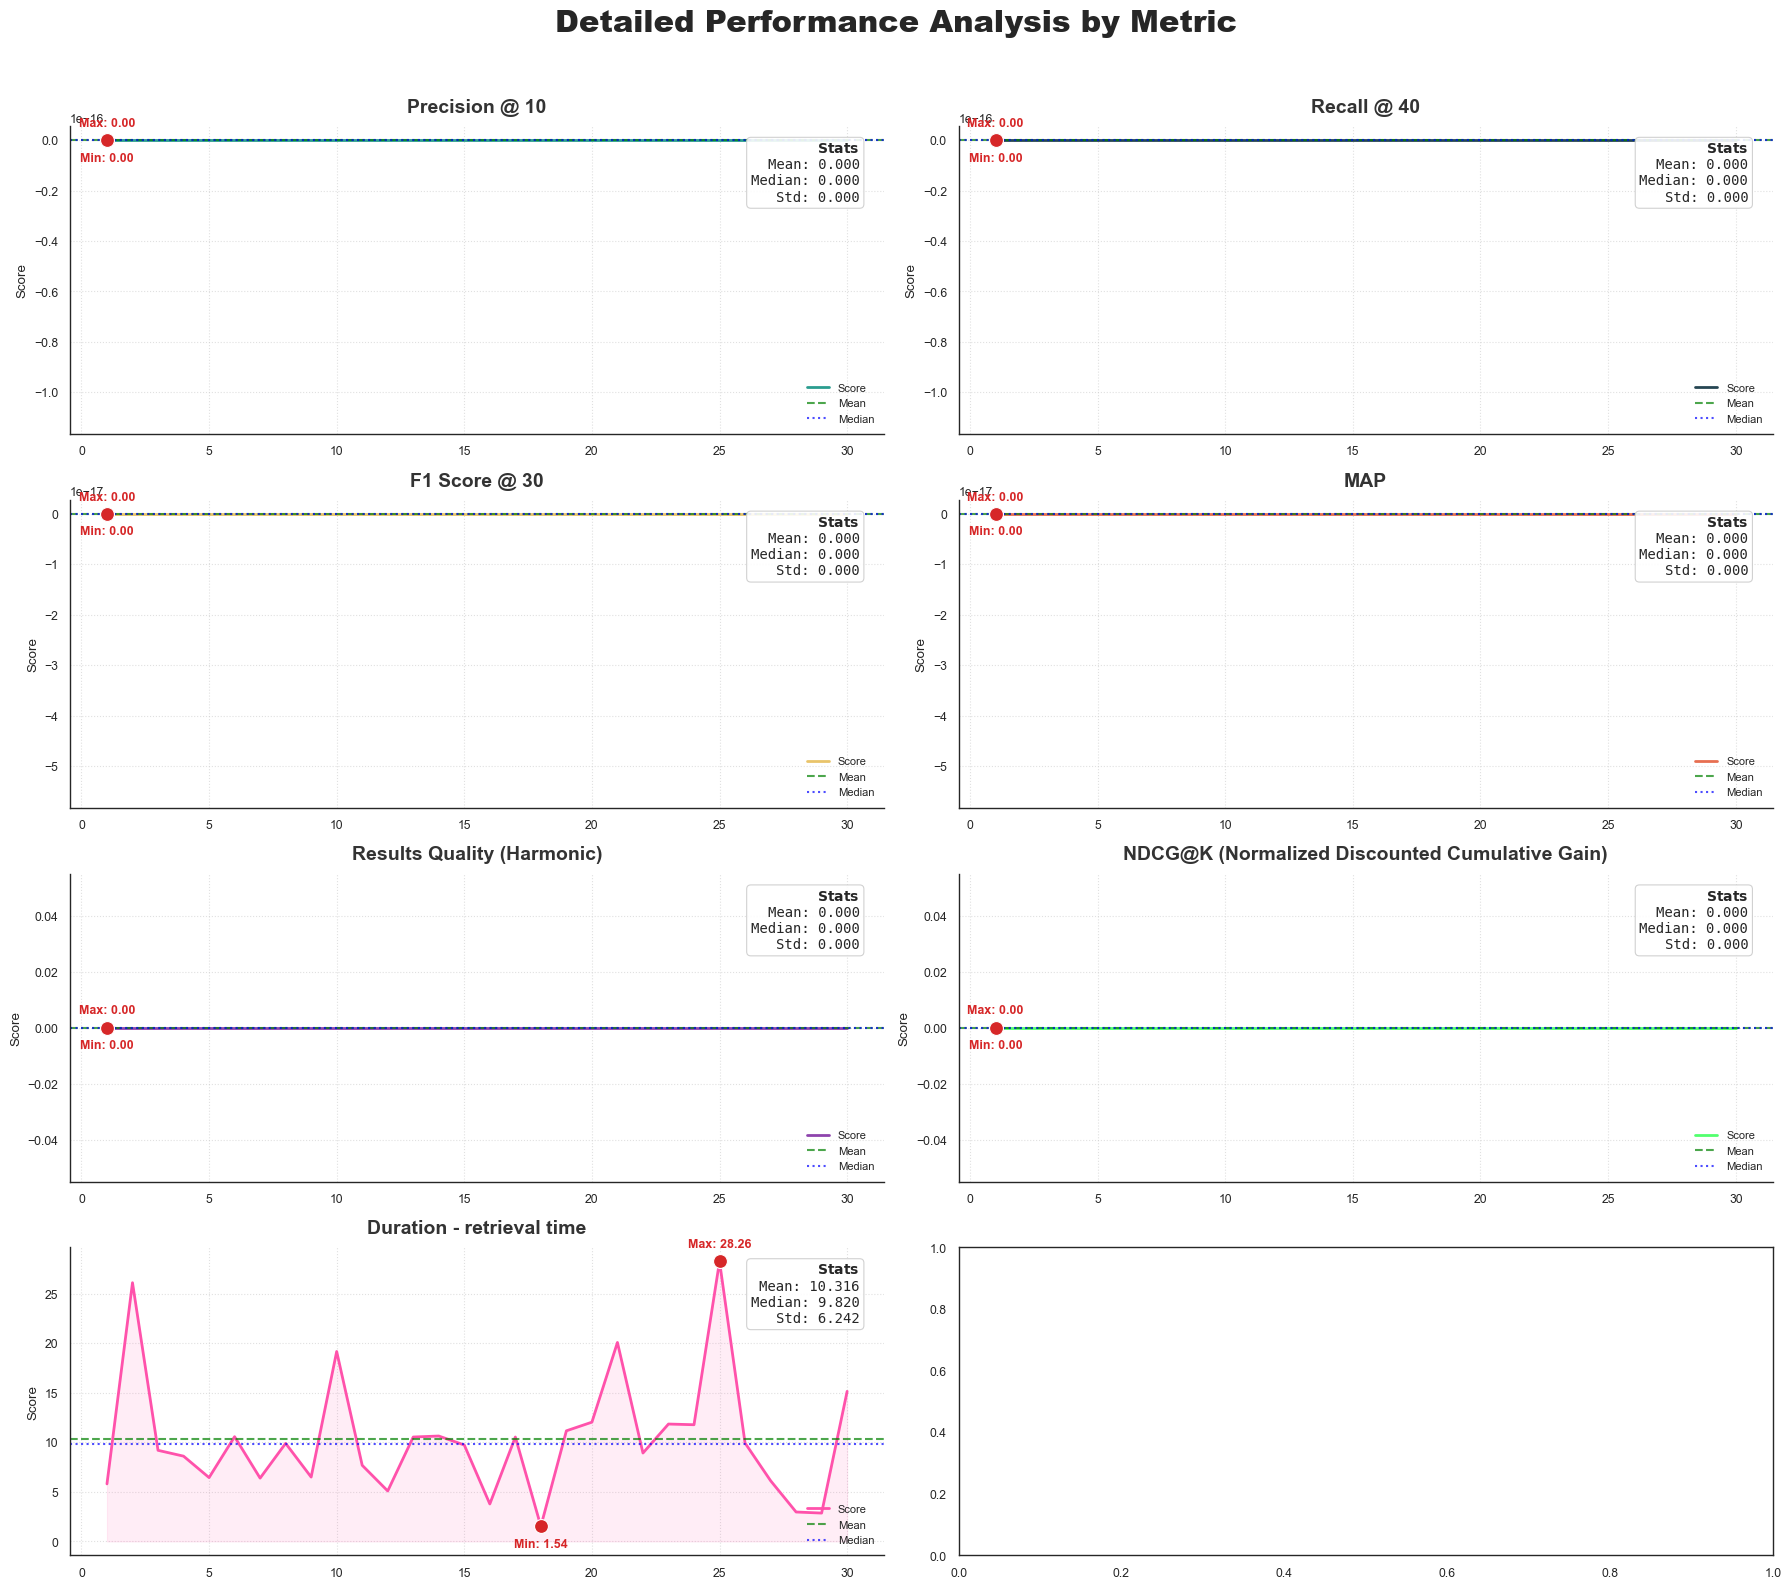

In [64]:
option3_res = get_results()
visulize_results(option3_res)

## Option4

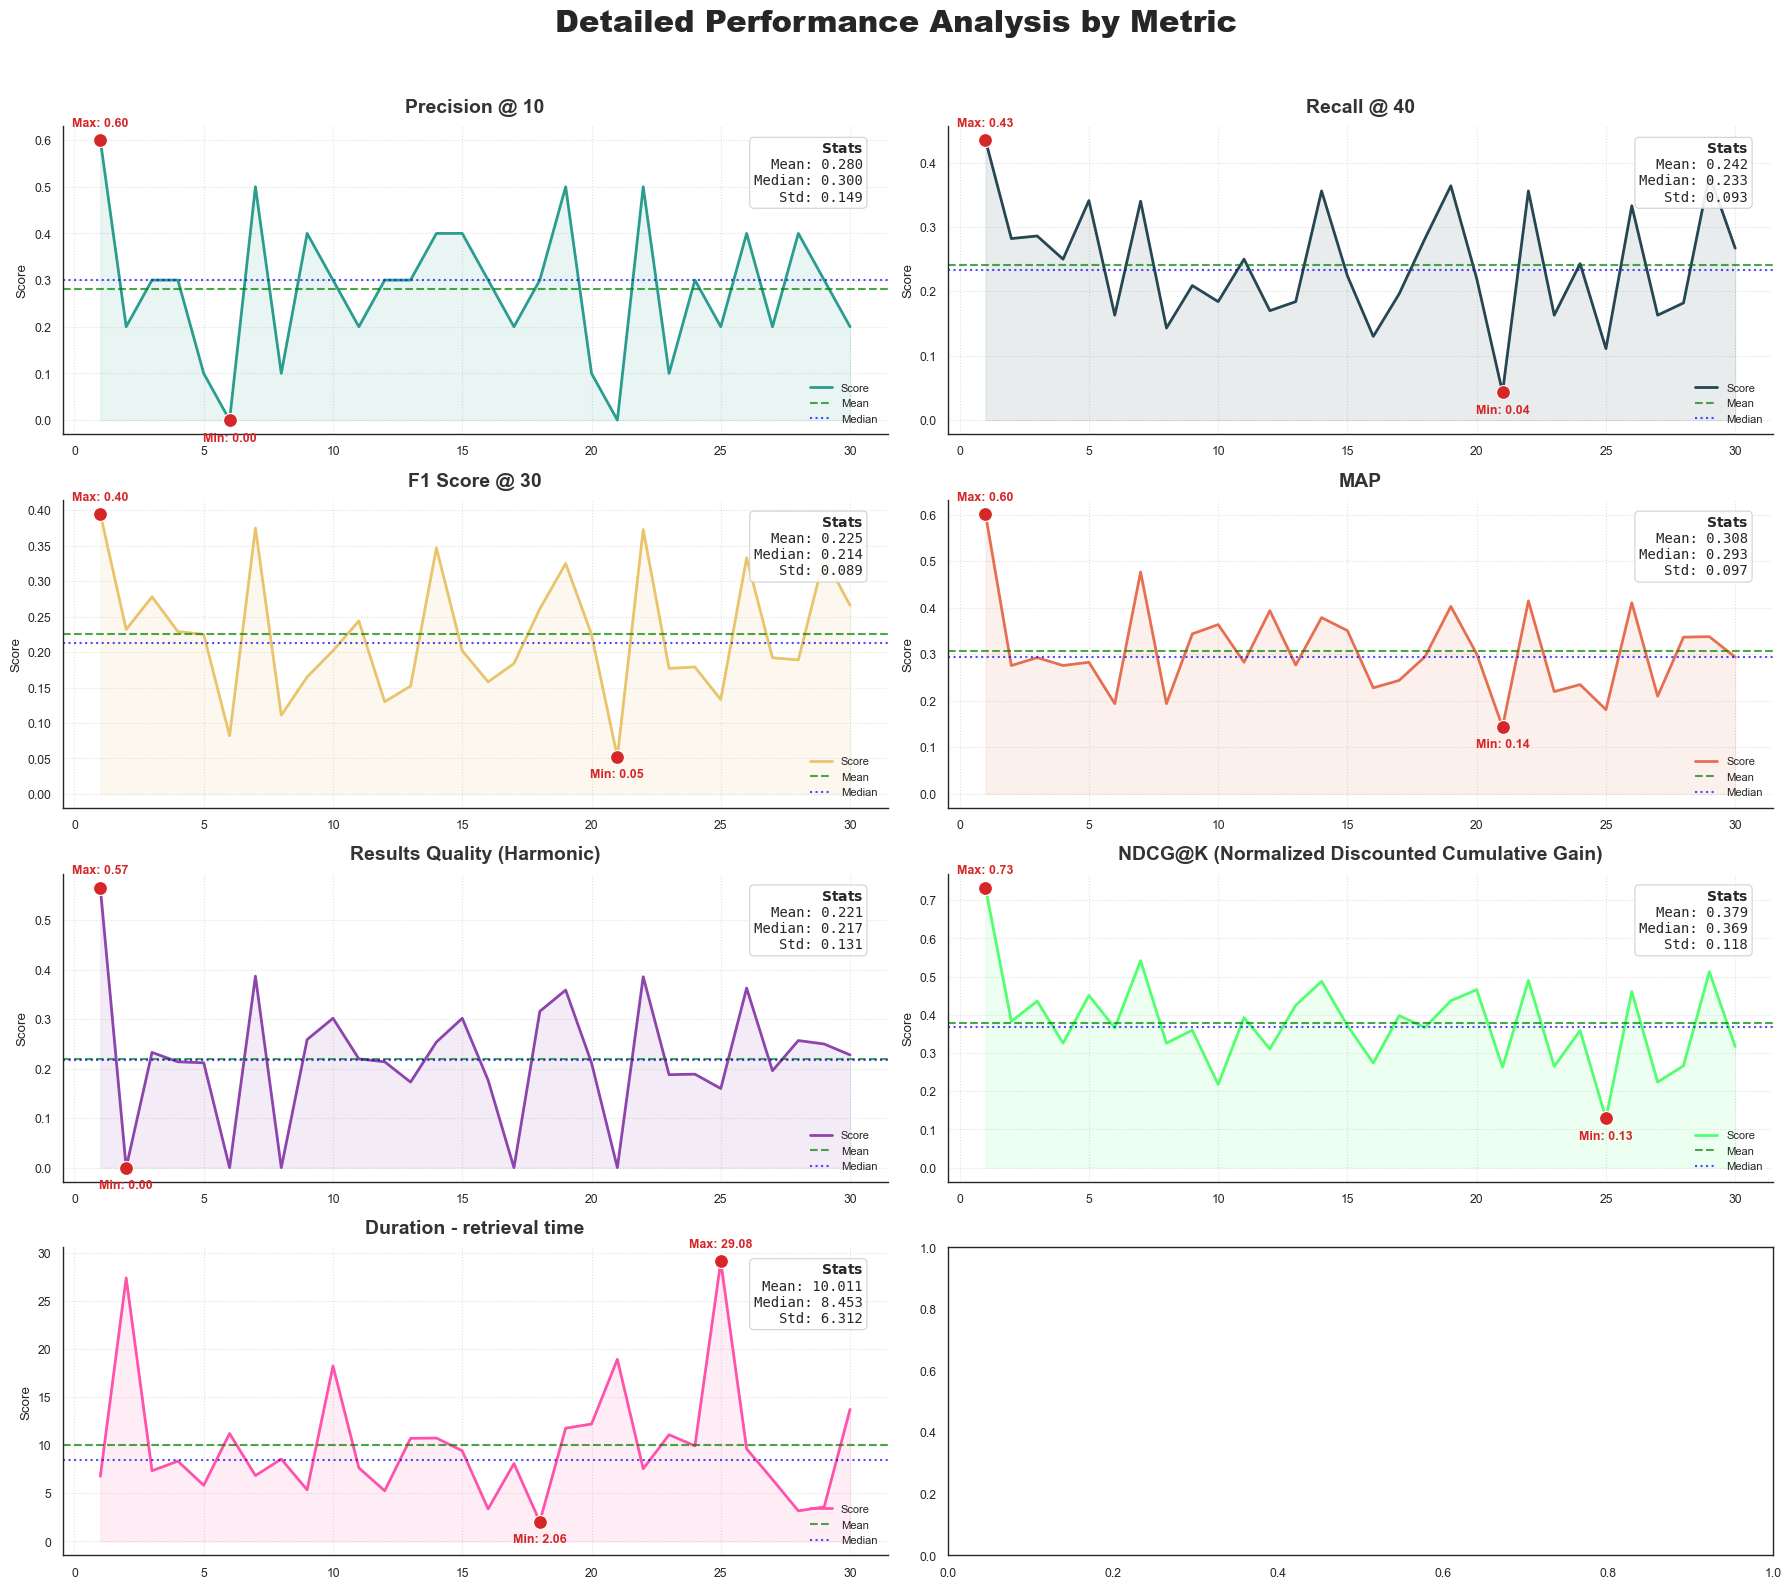

In [63]:
option4_res = get_results()
visulize_results(option4_res)

## Option5

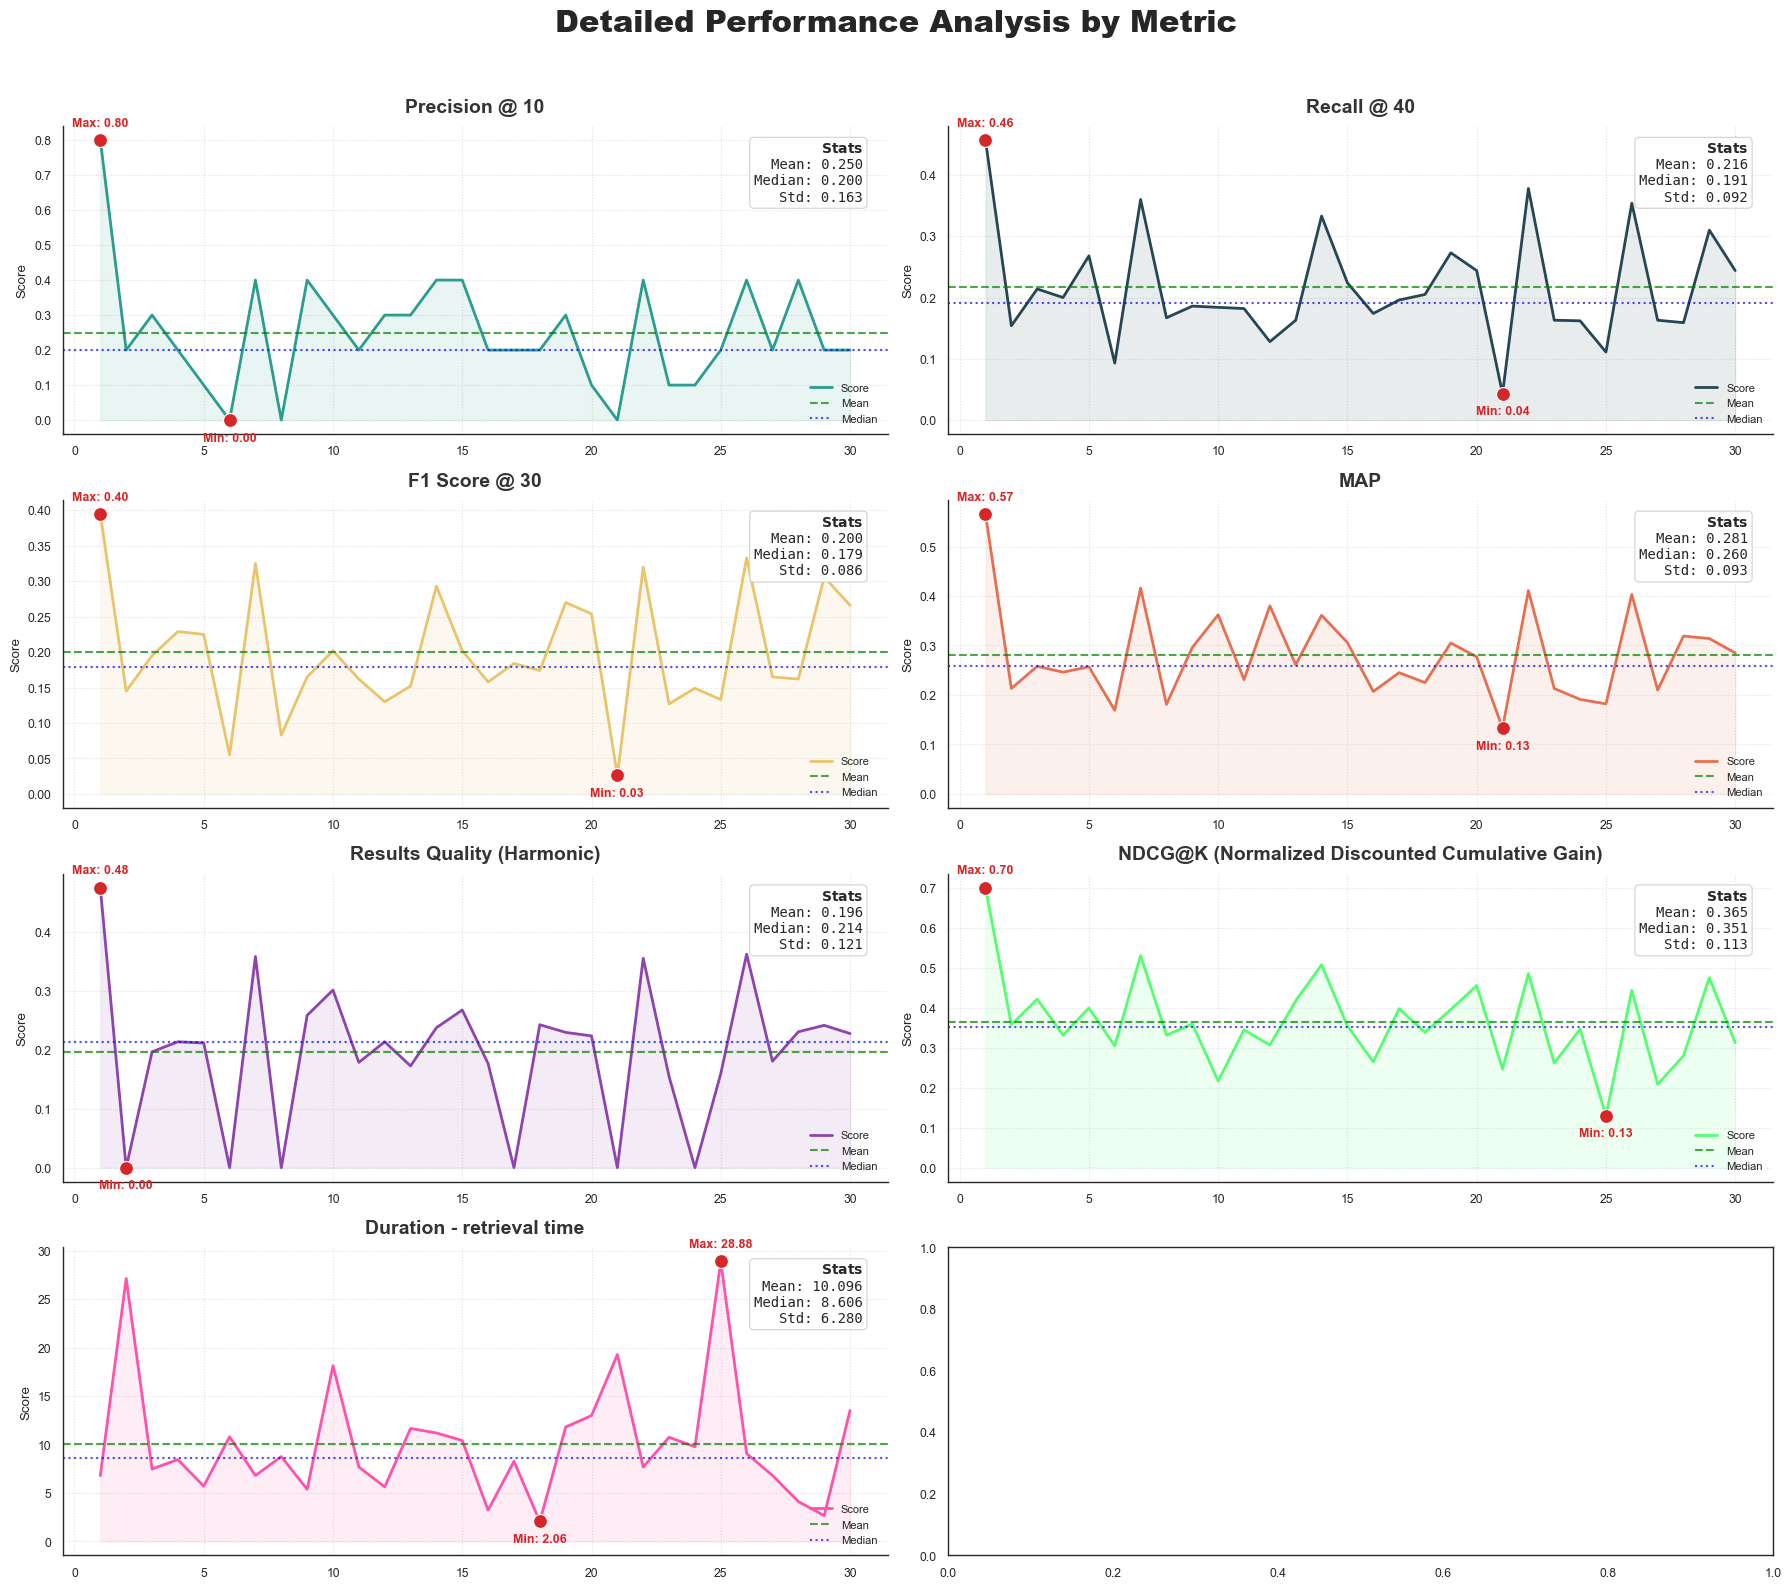

In [62]:
option5_res = get_results()
visulize_results(option5_res)

## Option6

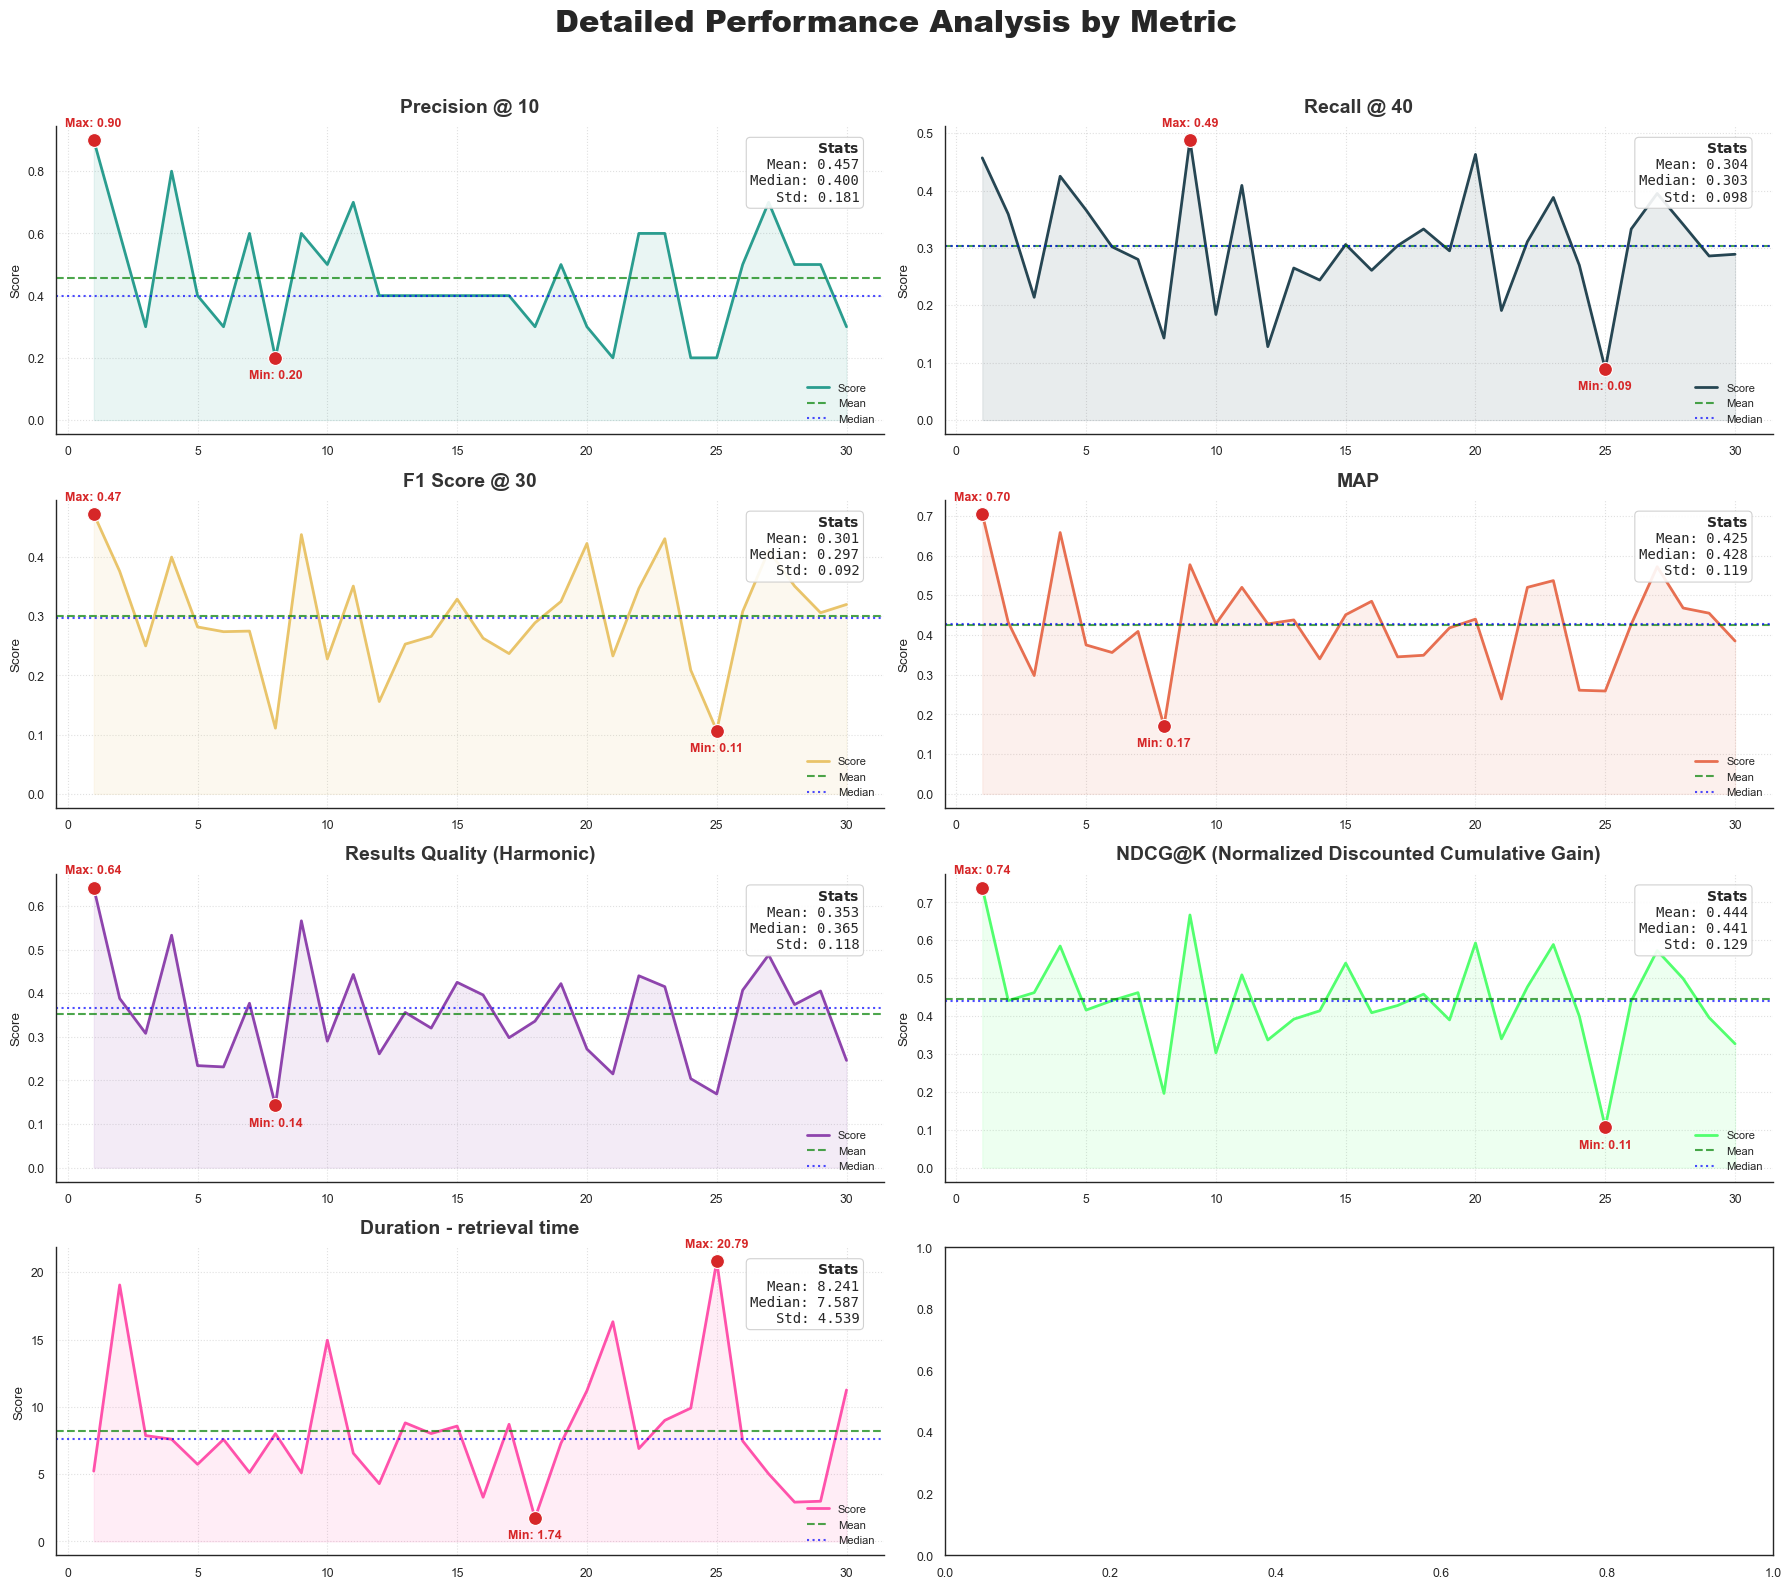

In [65]:
option6_res = get_results()
visulize_results(option6_res)

## Option7

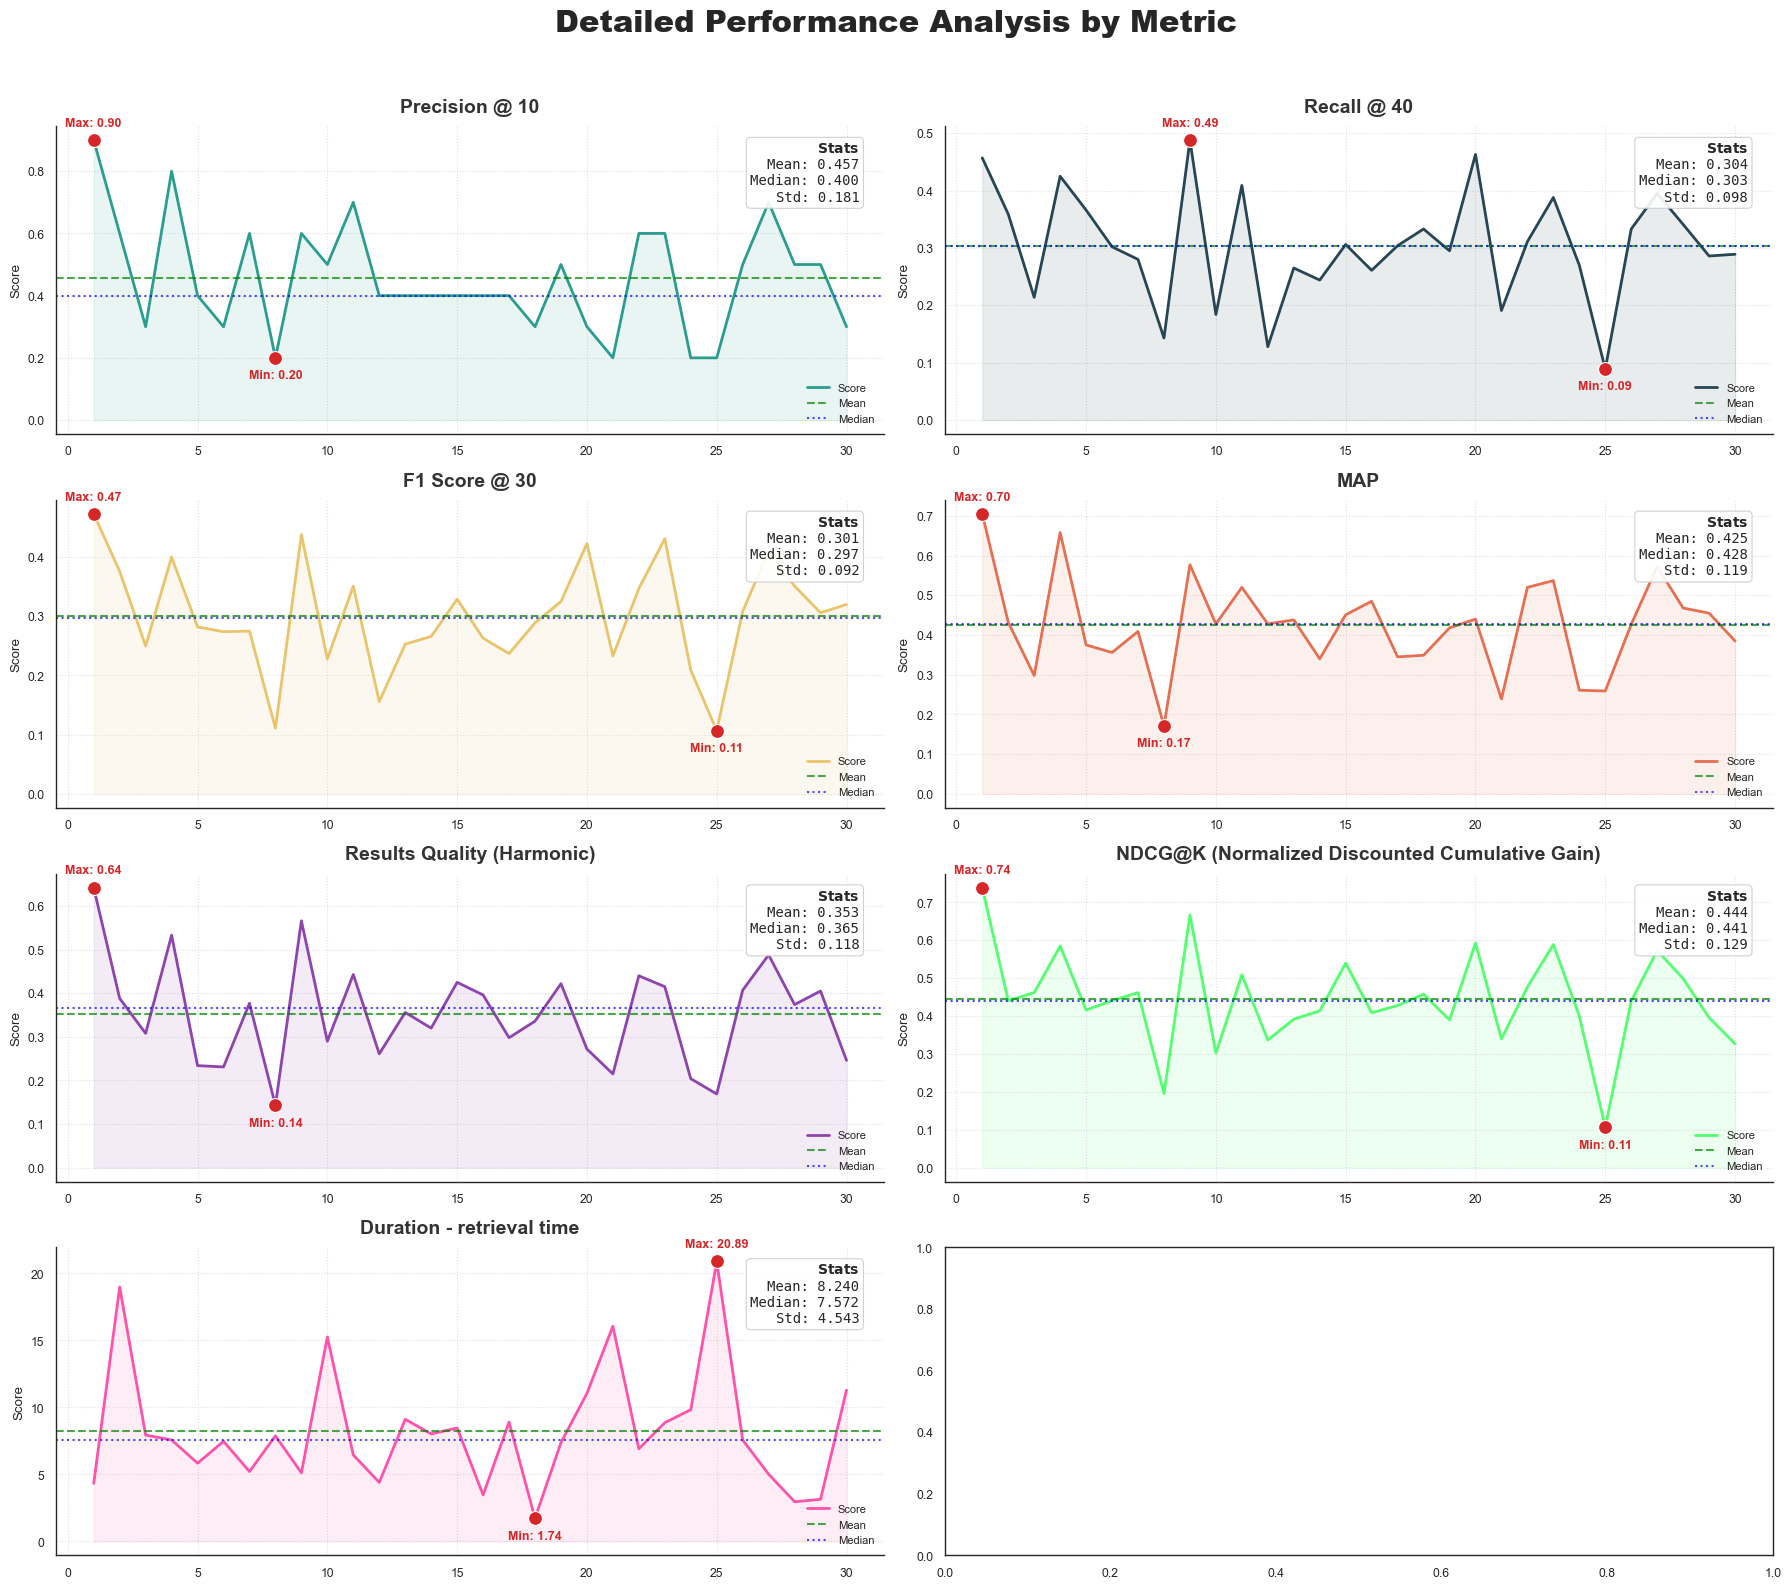

In [66]:
option7_res = get_results()
visulize_results(option7_res)

## Optio8

In [ ]:
option8_res = get_results()
visulize_results(option8_res)

## Option10

In [ ]:
option10_res = get_results()
visulize_results(option10_res)

In [68]:
import pickle
results = [option1_res, option2_res, option3_res, option4_res, option5_res, option6_res, option7_res, option8_res]
for i, res in enumerate(results):
    filename = f'results_{i}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(res, f)

In [ ]:
option2_res

[('Mount Everest climbing expeditions',
  5.822241544723511,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Great Fire of London 1666',
  26.8305606842041,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Nanotechnology materials science',
  9.57564663887024,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Fossil fuels climate change',
  8.616776466369629,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('DNA double helix discovery',
  6.597530126571655,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Printing press invention Gutenberg',
  10.797977685928345,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Ancient Egypt pyramids pharaohs',
  6.297183990478516,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Gothic literature Mary Shelley',
  10.798666000366211,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Robotics automation industry',
  6.729834794998169,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0),
 ('Television invention broadcast media'

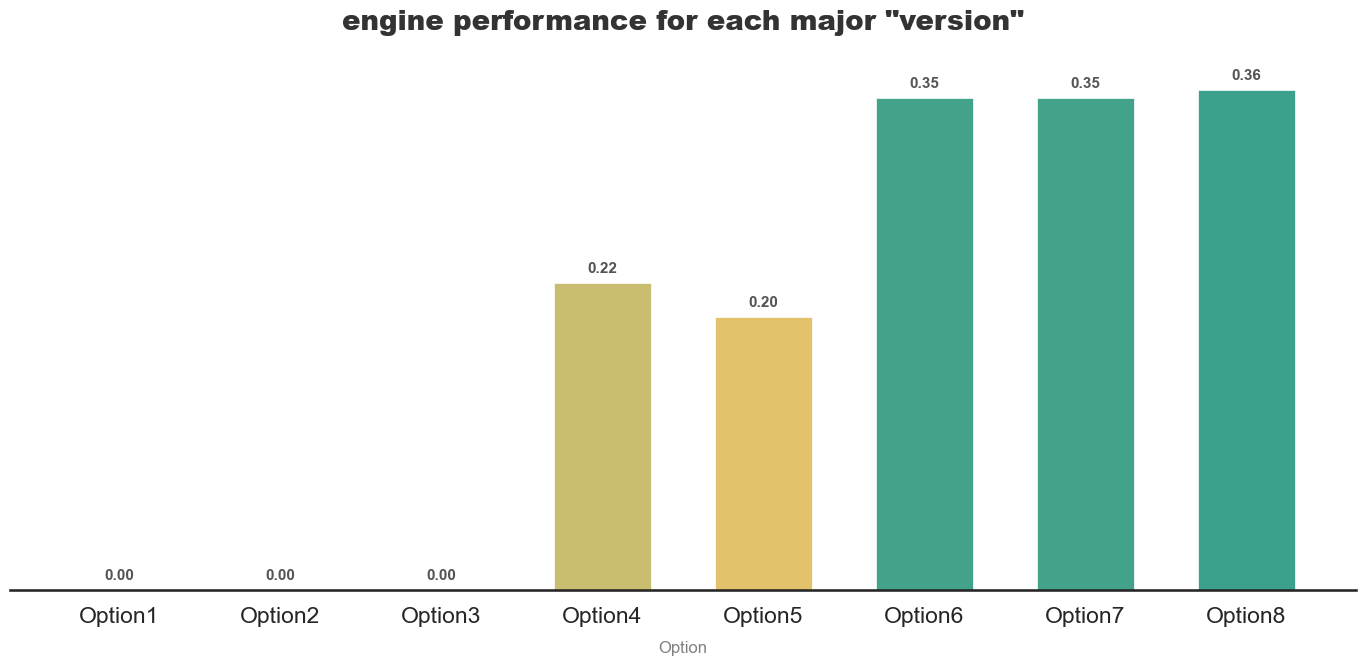

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def plot_quality_scores_modern(scores_list):
    """
    מייצרת ויזואליזציה יוקרתית עבור רשימה קצרה של ציונים (למשל 9).
    """
    # 1. הכנת הנתונים
    # וודא שיש לנו אינדקסים (Query 1, Query 2...)
    x_labels = [f'Option{i+1}' for i in range(len(scores_list))]
    df = pd.DataFrame({'Query': x_labels, 'Score': scores_list})
    
    # 2. הגדרות עיצוב וצבעים
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # יצירת מפת צבעים מותאמת אישית: מאדום (חלש) לצהוב (בינוני) לטורקיז (חזק)
    # זה נותן אפקט ויזואלי חזק של "איכות"
    cmap = LinearSegmentedColormap.from_list("custom_quality", ["#e76f51", "#e9c46a", "#2a9d8f"])
    
    # נרמול הצבעים לפי ערכי המינימום והמקסימום של הציונים
    norm = plt.Normalize(min(scores_list) * 0.9, max(scores_list) * 1.05)
    colors = [cmap(norm(value)) for value in scores_list]

    # 3. ציור העמודות (Bar Plot)
    bars = ax.bar(df['Query'], df['Score'], color=colors, width=0.6, edgecolor='white', linewidth=0.5)


    # 5. הוספת הערך המדויק מעל כל עמודה (Annotation)
    for bar, score in zip(bars, scores_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

    # 6. ליטוש סופי (Polishing)
    # הסרת מסגרות
    sns.despine(left=True, bottom=False)
    
    # כותרות
    plt.title('engine performance for each major "version"', fontsize=20, fontweight='heavy', color='#333333', pad=25)
    plt.ylabel('Quality Score (0-1)', fontsize=12, labelpad=10, color='gray')
    plt.xlabel('Option', fontsize=12, labelpad=10, color='gray')
    
    # הסרת הטיקים בציר ה-Y למראה נקי (כי המספרים כבר כתובים מעל העמודות)
    ax.yaxis.set_visible(False)
    
    # הוספת גריד עדין רק לציר Y אם רוצים (כאן ביטלנו את ציר Y, אז לא חובה)
    # אבל נשאיר רקע נקי לחלוטין.

    plt.tight_layout()
    return plt
scores = []
for result in results:
    rq = [element[2] for element in result]
    scores.append(sum(rq) / len(rq))
plt_obj = plot_quality_scores_modern(scores)
plt_obj.show()

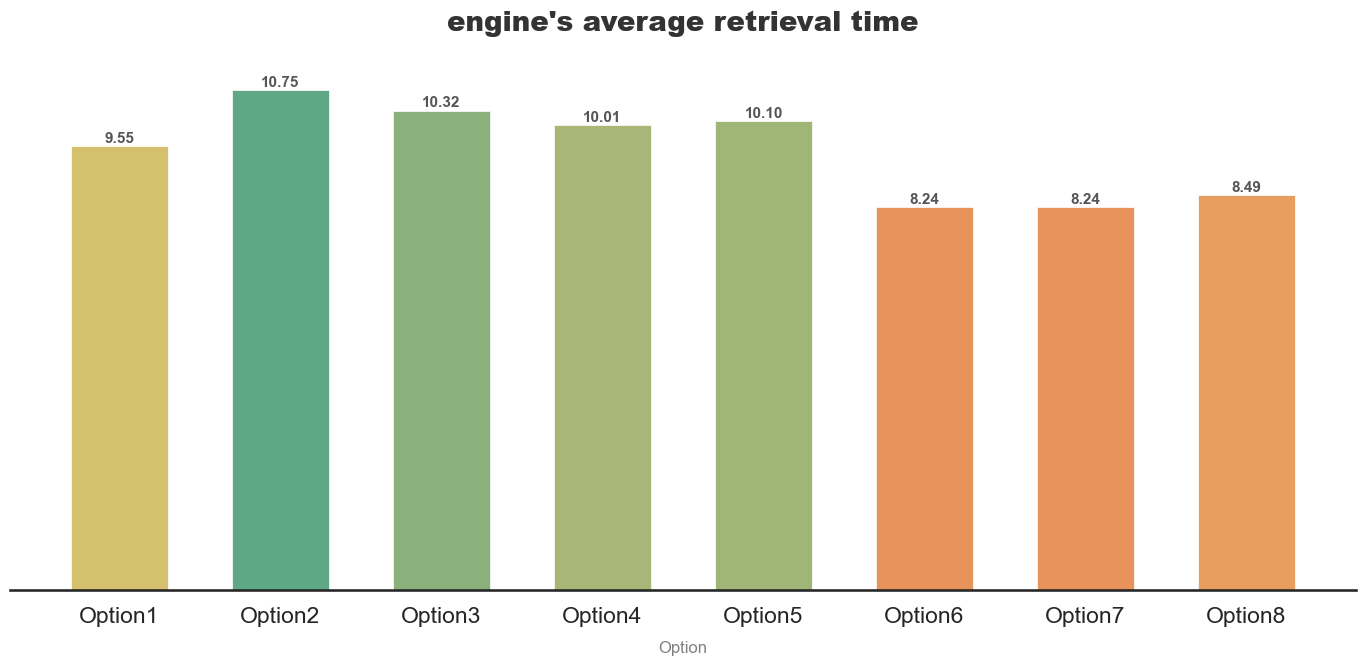

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def plot_quality_scores_modern(scores_list):
    """
    מייצרת ויזואליזציה יוקרתית עבור רשימה קצרה של ציונים (למשל 9).
    """
    # 1. הכנת הנתונים
    # וודא שיש לנו אינדקסים (Query 1, Query 2...)
    x_labels = [f'Option{i+1}' for i in range(len(scores_list))]
    df = pd.DataFrame({'Query': x_labels, 'Score': scores_list})
    
    # 2. הגדרות עיצוב וצבעים
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # יצירת מפת צבעים מותאמת אישית: מאדום (חלש) לצהוב (בינוני) לטורקיז (חזק)
    # זה נותן אפקט ויזואלי חזק של "איכות"
    cmap = LinearSegmentedColormap.from_list("custom_quality", ["#e76f51", "#e9c46a", "#2a9d8f"])
    
    # נרמול הצבעים לפי ערכי המינימום והמקסימום של הציונים
    norm = plt.Normalize(min(scores_list) * 0.9, max(scores_list) * 1.05)
    colors = [cmap(norm(value)) for value in scores_list]

    # 3. ציור העמודות (Bar Plot)
    bars = ax.bar(df['Query'], df['Score'], color=colors, width=0.6, edgecolor='white', linewidth=0.5)


    # 5. הוספת הערך המדויק מעל כל עמודה (Annotation)
    for bar, score in zip(bars, scores_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

    # 6. ליטוש סופי (Polishing)
    # הסרת מסגרות
    sns.despine(left=True, bottom=False)
    
    # כותרות
    plt.title("engine's average retrieval time", fontsize=20, fontweight='heavy', color='#333333', pad=25)
    plt.ylabel('Duration(Seconds)', fontsize=12, labelpad=10, color='gray')
    plt.xlabel('Option', fontsize=12, labelpad=10, color='gray')
    
    # הסרת הטיקים בציר ה-Y למראה נקי (כי המספרים כבר כתובים מעל העמודות)
    ax.yaxis.set_visible(False)
    
    # הוספת גריד עדין רק לציר Y אם רוצים (כאן ביטלנו את ציר Y, אז לא חובה)
    # אבל נשאיר רקע נקי לחלוטין.

    plt.tight_layout()
    return plt
scores = []
for result in results:
    rq = [element[1] for element in result]
    scores.append(sum(rq) / len(rq))
plt_obj = plot_quality_scores_modern(scores)
plt_obj.show()